In [2]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors import get_factor_bbox_multiple_T, get_factor_reproject_lines_multiple_T,get_factor_reproject_kp_multiple_T, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot

REenable line below


In [3]:

# global_info = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_166_sample_ground_plane/global_information.json'
global_info = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_165_roca_retrieval_no_z_gt_scale_fix_z_limits/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] = 'False'

target_folder = global_config["general"]["target_folder"].replace('/scratch2/','/scratches/octopus_2/')
models_folder_read = global_config["general"]["models_folder_read"].replace('/scratch2/','/scratches/octopus_2/')
top_n_retrieval = global_config["keypoints"]["matching"]["top_n_retrieval"]
top_n_for_translation = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["top_n_for_translation"]
pose_config = global_config["pose_and_shape"]["pose"]
sensor_width = pose_config["sensor_width"]
device = torch.device("cuda:{}".format(global_config["general"]["gpu"]))
torch.cuda.set_device(device)
model_to_infos = get_model_to_infos()

with open(target_folder + '/global_stats/visualisation_images.json','r') as open_f:
    visualisation_list = json.load(open_f)

  0%|          | 0/47948 [00:00<?, ?it/s]

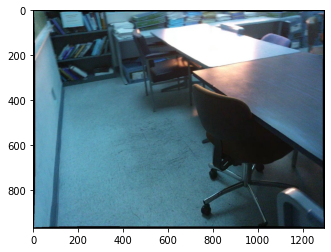

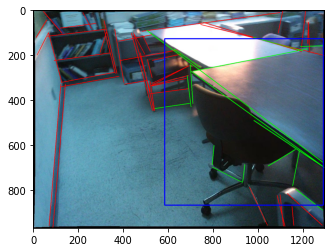

[[-0.9329994401134649, 0.0859466807101367, -0.34946417959909803], [0.24415516393533007, 0.8645684520900248, -0.43921480800898627], [0.2643866499497902, -0.4951106540214706, -0.827626207658239]]
[[-0.59525053 -0.37332007  0.        ]
 [-0.59525053 -0.37332007  0.35714286]
 [-0.59525053 -0.37332007  0.71428571]
 [-0.59525053 -0.37332007  1.07142857]]


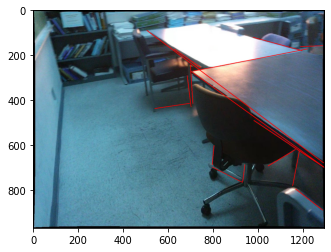

/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

 68%|██████▊   | 32748/47948 [00:01<00:00, 17101.43it/s]


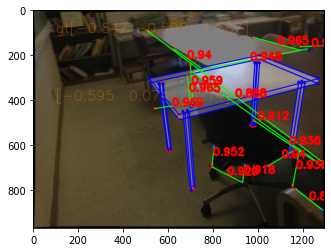

In [5]:
for name in tqdm(os.listdir(target_folder + '/poses_R')):
        
        retrieval = name.rsplit('_',1)[0]
        detection = name.rsplit('_',2)[0]
        gt_name = name.rsplit('_',3)[0]

        
        # if "scene0050_02-000400_00" not in name or "000_00.json" not in name:
        #     continue

        # if "scene0011_01-000400_00" not in name or "000_00.json" not in name:
        #     continue

        # if "scene0030_00-000600_00" not in name or "000_00.json" not in name:
        #     continue

        # if "scene0030_00-000600_01" not in name or "000_00.json" not in name:
        #     continue

        if "scene0030_00-002100_02" not in name or "000_00.json" not in name:
            continue

        with open(target_folder + '/nn_infos/' + detection + '.json','r') as open_f:
            retrieval_list = json.load(open_f)["nearest_neighbours"]

        with open(target_folder + '/gt_infos/' + gt_name + '.json','r') as open_f:
            gt_infos = json.load(open_f)

        if gt_infos["img"] not in visualisation_list:
            continue

        if not os.path.exists(target_folder + '/lines_2d_filtered_vis/' + detection + '.png'):
            print(target_folder + '/lines_2d_filtered_vis/' + detection + '.png')
            break

        with open(target_folder + '/segmentation_infos/' + detection + '.json','r') as open_f:
            segmentation_infos = json.load(open_f)

        with open(target_folder + '/bbox_overlap/' + detection + '.json','r') as f:
            bbox_overlap = json.load(f)

        input_img = cv2.imread(target_folder + '/images/' + gt_infos['img'])
        plt.imshow(input_img)
        plt.show()

        lines = cv2.imread(target_folder + '/lines_2d_filtered_vis/' + detection + '.png')
        plt.imshow(lines)
        plt.show()

        nn_index = int(retrieval.split('_')[-1])

        if nn_index >= len(retrieval_list):
            continue
    
        # convert pixel to pixel bearing
        f = gt_infos["focal_length"]
        w = gt_infos["img_size"][0]
        h = gt_infos["img_size"][1]
        sw = pose_config["sensor_width"]
        enforce_same_length = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["enforce_same_length"]
        # get infos
        B = get_pb_real_grid(w,h,f,sw,device)

        # print('Use gt R for debugging')
        # R  = gt_infos["objects"][bbox_overlap['index_gt_objects']]["rot_mat"]
        with open(target_folder + '/poses_R/' + name,'r') as file:
            R = json.load(file)["predicted_r"]
        # print('Use gt retrieval')
        # retrieval_list[nn_index]["model"] = gt_infos["objects"][bbox_overlap['index_gt_objects']]["model"]
        print(R)
        sp_rot = scipy_rot.from_matrix(R)
        tilt,azim,elev = sp_rot.as_euler('zyx',degrees=True)

        tilts,azims,elevs = [tilt-0.0001,tilt+0.0001,1],[azim-0.0001,azim+0.0001,1],[elev-0.0001,elev+0.0001,1]

        bbox = segmentation_infos["predictions"]["bbox"]

        gt_rot = gt_infos["objects"][bbox_overlap['index_gt_objects']]["rot_mat"]
        gt_trans = gt_infos["objects"][bbox_overlap['index_gt_objects']]["trans_mat"]

        gt_scaling = gt_infos["objects"][bbox_overlap['index_gt_objects']]["scaling"]

        # Ss = np.concatenate((0.5*np.reshape(np.array(scaling),(1,3)),np.reshape(np.array(scaling),(1,3))))

        # Ss = init_Ts((0.5,3,8),(0.5,3,8),(0.5,3,8))
        Ss = np.reshape(np.array(gt_scaling),(1,3))

        gt_z = gt_trans[2]

        xs,ys,zs = get_T_limits(f,[w,h],sensor_width,global_config["pose_and_shape_probabilistic"]["pose"],bbox,gt_z)
        if global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] == "True":
            catname_model = retrieval_list[nn_index]["model"].split('/')[1] + '_' + retrieval_list[nn_index]["model"].split('/')[2] 
            model_infos = model_to_infos[catname_model]
            height_object_center_above_ground = gt_scaling[1] *  (model_infos['bbox'][1] - model_infos['center'][1])
            Ts,Ts_ground = sample_Ts_ground_plane(np.array(R),height_object_center_above_ground,global_config["pose_and_shape_probabilistic"]["ground_plane_limits"],segmentation_infos["predictions"]["category"])
            Ts = filter_Ts(Ts,f,sw,w,h)


        elif global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] == "False":
            Ts = init_Ts(xs,ys,zs)

        if Ts.shape[0] == 0:
            Ts = np.array([[0,0,1]])
        
        print(Ts[:4])

        gt_pose_in_limits = check_gt_pose_in_limits(xs,ys,zs,tilts,elevs,azims,gt_trans,gt_rot)
        best_T_possible,best_R_possible = get_nearest_pose_to_gt(xs,ys,zs,tilts,elevs,azims,gt_trans,gt_rot)

        signal = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"]

        # compute factors
        factors = []
        Ts = torch.Tensor(Ts)

        if signal == 'bbox' or signal == 'lines':
            path =  global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"] + "/" + retrieval_list[nn_index]["model"].split('/')[1] + '_' + retrieval_list[nn_index]["model"].split('/')[2] + '.npy'
            if not os.path.exists(path):
                path = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_self_scanned"].replace('/scratch2/','/scratches/octopus_2/') + '/' + retrieval_list[nn_index]["model"].split('/')[1] + '_' + retrieval_list[nn_index]["model"].split('/')[2] + '.npy'

            if os.path.exists(path):
                lines_3D = load_lines_3D(path)
            else:
                lines_3D = np.array([[0.,0.,0,0.5,0.,0]]).astype(np.float32)


            # lines_3D = lines_3D * np.array(scaling + scaling).astype(np.float32)
            # print('dont multuiply by scale here anymore')
            mask_length = np.sum((lines_3D[:,:3] - lines_3D[:,3:6])**2,axis=1)**0.5 > global_config["pose_and_shape_probabilistic"]["reproject_lines"]["min_length_line"]
            lines_3D = lines_3D[mask_length]
            
            line_dirs_3D = torch.from_numpy(lines_3D[:,:3] - lines_3D[:,3:6])
            line_dirs_3D = line_dirs_3D / torch.linalg.norm(line_dirs_3D,axis=1).unsqueeze(1).tile(1,3)
            # because lines saved as points but need as point + direction 
            lines_3D[:,3:6] = lines_3D[:,3:6] - lines_3D[:,:3]


            line_path = target_folder + '/lines_2d_filtered/' + detection + '.npy'
            lines_2D = torch.Tensor(np.load(line_path)).long()

            # lines_2D = lines_2D[1:2]

            for line in lines_2D:
                y_start, x_start, y_end, x_end = [int(val) for val in line]
                cv2.line(input_img, (x_start, y_start), (x_end, y_end), [255,0,0], 2)
            plt.imshow(input_img)
            plt.show()



            

            if len(lines_2D.shape) == 1 or lines_3D.shape[0] == 0:
                best_T_index = 0
                best_S_index = 0
                max_factor = 0
                lines_available = False
            else:
                lines_available = True
                mask = ~(lines_2D[:,:2] == lines_2D[:,2:4]).all(dim=1)
                lines_2D = lines_2D[mask]
            
                if global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] == 'bbox':
                    factors_batch,_ = get_factor_bbox_multiple_T(torch.Tensor(R).to(device),torch.Tensor(Ts).to(device),torch.from_numpy(lines_3D).to(device),torch.Tensor(bbox).to(device),f,w,h,sw)
                elif global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] == 'lines':
                    multiplier_lines = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"]
                    multiplier_lines = 0.1
                    factors_batch,_ = get_factor_reproject_lines_multiple_T_with_Scale(torch.Tensor(R).to(device),torch.Tensor(Ts).to(device),torch.Tensor(Ss).to(device),torch.from_numpy(lines_3D).to(device),lines_2D.to(device),B.to(device),top_n_for_translation,f,multiplier_lines,enforce_same_length)
                factors = factors_batch.cpu().tolist()
                best_index_overall = factors.index(max(factors))
                best_T_index = best_index_overall // Ss.shape[0]
                best_S_index = best_index_overall % Ss.shape[0]
                max_factor = max(factors)


        elif signal == 'points':
            points_3D,_ = load_ply(global_config["pose_and_shape_probabilistic"]["reproject_lines"]["point_dir"] + '/' + retrieval_list[nn_index]["model"].split('/')[1] + '/' + retrieval_list[nn_index]["model"].split('/')[2] + '.ply')
            # with open(target_folder + '/kp_orig_img_size/' + detection + '.json','r') as file:
            #     points_2D = json.load(file)["pixels_real_orig_size"]
            points_2D_flipped = np.load(target_folder + '/keypoints_filtered/' + detection + '.npy')
            points_2D = points_2D_flipped * 0
            points_2D[:,0] = points_2D_flipped[:,1]
            points_2D[:,1] = points_2D_flipped[:,0]
            points_2D = torch.Tensor(points_2D).long()
            # points_2D = torch.flip(points_2D,dims=[0,1])
            # print(points_2D[:3])
            points_available = True
            multiplier_points = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_points"]
            point_threshold = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["point_threshold"]
            use_threshold = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["use_point_threshold"]
            factors_batch,_ = get_factor_reproject_kp_multiple_T(torch.Tensor(R).to(device),torch.Tensor(Ts).to(device),points_3D.to(device),points_2D.to(device),B,top_n_for_translation,f,multiplier_points,point_threshold,use_threshold)
            factors = factors_batch.cpu().tolist()
            best_T_index = factors.index(max(factors))
            max_factor = max(factors)

        T = Ts[best_T_index]
        S = Ss[best_S_index]
        n_indices = 1


        create_k3d_plot(np.array(Ts),np.array(factors),gt_trans)

        pose_information = create_pose_info_dict(np.array(R),T,n_indices,max_factor,gt_pose_in_limits,gt_rot,gt_trans,best_R_possible,best_T_possible,xs,ys,zs,tilts,elevs,azims,gt_scaling)

        distance_gt = torch.sum((Ts - torch.Tensor(gt_trans).unsqueeze(0).repeat(Ts.shape[0],1))**2,dim=1)
        _,indices = torch.sort(distance_gt)
        closest_gt_t_index = torch.argmin(distance_gt).item()

        distance_gt = torch.sum((torch.Tensor(Ss) - torch.Tensor(gt_scaling).unsqueeze(0).repeat(Ss.shape[0],1))**2,dim=1)
        _,indices = torch.sort(distance_gt)
        closest_gt_s_index = torch.argmin(distance_gt).item()
        # for s in range(0,Ss.shape[0]):
        #     S = Ss[s]
        #     for l in tqdm(range(0,Ts.shape[0])):
            # for l in tqdm(range(best_index,best_index+1)):
        # for which,l,s in zip(['selected','closest_gt'],[best_T_index,closest_gt_t_index],[best_S_index,closest_gt_s_index]):
        for which,l,s in zip(['selected'],[best_T_index],[best_S_index]):
            T = Ts[l]
            S = Ss[s]

            img_path = target_folder + '/images/' + gt_infos["img"]
            model_path = global_config["dataset"]["dir_path"].replace('/scratch2/','/scratches/octopus_2/') + retrieval_list[nn_index]["model"]

            if signal == 'bbox':
                if not lines_3D.shape[0] == 0:
                    img = plot_bbox(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,model_path,img_path,sw,device,lines_3D,f,torch.Tensor(bbox))
            elif signal == 'lines':
                if lines_available:
                    img = plot_lines_T(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),S,model_path,img_path,sw,device,lines_3D,lines_2D,B,f,top_n_for_translation,multiplier_lines,enforce_same_length)
                else:
                    img = cv2.imread(target_folder + '/images/' + gt_infos["img"])
            elif signal == 'points':
                if points_available:
                    img = plot_points_T(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,model_path,img_path,sw,device,points_3D,points_2D,B,f,top_n_for_translation,multiplier_points,point_threshold,use_threshold)
                else:
                    img = cv2.imread(target_folder + '/images/' + gt_infos["img"])
            # cv2.imwrite(output_path.replace('/poses/','/T_lines_vis/').replace('.json','_'+str(l).zfill(3) +'.png'),img)


            cv2.putText(img, 'gt' + str(np.round(gt_trans,3)), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)

            cv2.putText(img, str(np.round(T.numpy(),3)), (100,400), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)

            plt.imshow(img)
            plt.show
        break
    

    

In [19]:
/scratch2/fml35/experiments/leveraging_geometry_for_shape/exp_175_sample_ground_plane_single_cat/lines_2d_filtered_vis/scene0671_00-000000_03.png

SyntaxError: invalid syntax (778776571.py, line 1)